In [34]:
import sys 
sys.path.append("..\\..\\src")
import torch.nn as nn
import torch.nn.functional as F
import torch
import cv2
import pandas as pd
import numpy as np
from grad_cam import GradCam,show_cam_on_image
from pandas import DataFrame
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torchvision import transforms
import torch.optim as optim
import matplotlib.pyplot as plt
from datasets import PILImageDataset
from PIL import Image


In [45]:
img_size = (512, 512)
transform = transforms.Compose(
    [transforms.Resize(img_size),
     transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

df = pd.read_csv('df.csv')
model_path = 'new_test.pt'

trainset = PILImageDataset(df, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True)

In [46]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.conv_list = nn.ModuleList([nn.Conv2d(3, 6, 17), nn.Conv2d(6, 16, 11),
                          nn.Conv2d(16, 32, 7), nn.Conv2d(32, 64, 5)])
        self.fc_list = nn.ModuleList([nn.Linear(43264, 120), nn.Linear(120, 84), nn.Linear(84, 10)])
    
    def feed_forward(self, x, nnlayer, conv =True):
        if conv==True:
            x = self.pool(F.relu(nnlayer(x)))
        else:
            x = F.relu(nnlayer(x))
        return x            
            
    
    def forward(self, x):
        for conv_layer in self.conv_list:
            x = self.feed_forward(x, conv_layer, conv =True)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        for fc in self.fc_list:
            x = self.feed_forward(x, fc, conv =False)
        return x

model = Net()

In [47]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

for epoch in range(10):  # loop over the dataset multiple times
    print('epoch : ', epoch)
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        print('running_loss : ', running_loss)

print('Finished Training')

epoch :  0
running_loss :  2.3080973625183105
epoch :  1
running_loss :  2.30783748626709
epoch :  2
running_loss :  2.3073513507843018
epoch :  3
running_loss :  2.306657314300537
epoch :  4
running_loss :  2.305783271789551
epoch :  5
running_loss :  2.3047585487365723
epoch :  6
running_loss :  2.303588628768921
epoch :  7
running_loss :  2.3023202419281006
epoch :  8
running_loss :  2.3009886741638184
epoch :  9
running_loss :  2.2996408939361572
Finished Training


In [48]:
'''
def preprocess_image(img):
    # Vestige functions can be deleted. Only needed if one needds to check network on rgb images
    means = (0.5, 0.5, 0.5)
    stds =  (0.5, 0.5, 0.5)

    preprocessed_img = img.copy()[:, :, ::-1]
    for i in range(3):
        preprocessed_img[:, :, i] = preprocessed_img[:, :, i] - means[i]
        preprocessed_img[:, :, i] = preprocessed_img[:, :, i] / stds[i]
    preprocessed_img = \
        np.ascontiguousarray(np.transpose(preprocessed_img, (2, 0, 1)))
    preprocessed_img = torch.from_numpy(preprocessed_img)
    preprocessed_img.unsqueeze_(0)
    inputs = preprocessed_img.requires_grad_(True)
    return inputs
inputs = transform(img)
'''

'\ndef preprocess_image(img):\n    # Vestige functions can be deleted. Only needed if one needds to check network on rgb images\n    means = (0.5, 0.5, 0.5)\n    stds =  (0.5, 0.5, 0.5)\n\n    preprocessed_img = img.copy()[:, :, ::-1]\n    for i in range(3):\n        preprocessed_img[:, :, i] = preprocessed_img[:, :, i] - means[i]\n        preprocessed_img[:, :, i] = preprocessed_img[:, :, i] / stds[i]\n    preprocessed_img =         np.ascontiguousarray(np.transpose(preprocessed_img, (2, 0, 1)))\n    preprocessed_img = torch.from_numpy(preprocessed_img)\n    preprocessed_img.unsqueeze_(0)\n    inputs = preprocessed_img.requires_grad_(True)\n    return inputs\ninputs = transform(img)\n'

In [49]:
torch.save(model, model_path)

In [50]:
#img = cv2.imread('./data/Dog/dog.jpg', 1)
#img = cv2.imread('./data/Elephant/elephant.jpg', 1)
#img = cv2.imread('./data/Peacock/peacock.jpg', 1)
#img = cv2.imread('./data/Coffeepot/coffeepot.jpg', 1)
img = Image.open('./data/Elephant/elephant.jpg')
img = img.resize(img_size)

inputs = torch.unsqueeze(transform(img),0)

In [51]:
grad_cam = GradCam(model=model, use_cuda=False)
target_index = None
mask_dict = grad_cam(inputs, target_index)
for name, mask in mask_dict.items():
    cam, name, heatmap = show_cam_on_image(img, mask, name)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


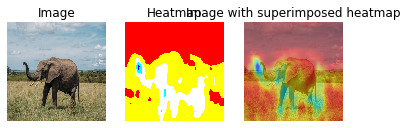

In [52]:
def plot_image_data(heatmap, cam, image):
    fig, axes = plt.subplots(nrows=1, ncols = 3)
    titles = ['Image', 'Heatmap', 'Image with superimposed heatmap']
    axes[0].imshow(image)
    axes[1].imshow(heatmap,)
    axes[2].imshow(cam)
    for i, ax in enumerate(axes):
        ax.axis('off')
        axes[i].set_title(titles[i])
    plt.show()
plot_image_data(heatmap, cam, img)